In [518]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns

# sklearn imports
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

# Metrics imports
from sklearn import metrics

In [625]:
#Read in the data
df = pd.read_csv("/Users/ianwood/Downloads/Bakery.csv")
#Day time = Weekend or Weekday
#Day part = Morning, afternoon, evening, night 
#Date Time = date and time stamp of a transaction
#Items of purchase = [ Coffee, Bread, Scandinavian, Hot Chocotlate, Cookies, Muffines, Medialuna, Tea, Pastry, Jam, Tartine, Farm House, Fudge]

In [626]:
#Removed Time element to just keep dates as we have what point in the day the order was taken 
df['DateTime'] = pd.to_datetime(df['DateTime'])

#Rounded up using the hour frequency unit
df['DateTime'] = df['DateTime'].dt.round(freq='h')
df['DateTime'] = pd.to_datetime(df['DateTime']).dt.time

df.head(10)

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,10:00:00,Morning,Weekend
1,2,Scandinavian,10:00:00,Morning,Weekend
2,2,Scandinavian,10:00:00,Morning,Weekend
3,3,Hot chocolate,10:00:00,Morning,Weekend
4,3,Jam,10:00:00,Morning,Weekend
5,3,Cookies,10:00:00,Morning,Weekend
6,4,Muffin,10:00:00,Morning,Weekend
7,5,Coffee,10:00:00,Morning,Weekend
8,5,Pastry,10:00:00,Morning,Weekend
9,5,Bread,10:00:00,Morning,Weekend


In [627]:
#Converted Datetime into hour integers 
# x.hour accessses the hour attribute of the datetime.time object and 
# Extracting it as an integer 
# 1 = 1am, 10 = 10am 
df['DateTime'] = df["DateTime"].apply(lambda x: x.hour)

In [628]:
df.dtypes

TransactionNo     int64
Items            object
DateTime          int64
Daypart          object
DayType          object
dtype: object

In [629]:
#Correct way of using df.drop() is by specifying the rows or columns to drop as its arguments 
#Conditional indexing with booleans, you need to use ~ negation operations instead of df.drop
df[~((df['DateTime']< 20) & (df['DateTime'] > 8))]
df

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Bread,10,Morning,Weekend
1,2,Scandinavian,10,Morning,Weekend
2,2,Scandinavian,10,Morning,Weekend
3,3,Hot chocolate,10,Morning,Weekend
4,3,Jam,10,Morning,Weekend
...,...,...,...,...,...
20502,9682,Coffee,15,Afternoon,Weekend
20503,9682,Tea,15,Afternoon,Weekend
20504,9683,Coffee,15,Afternoon,Weekend
20505,9683,Pastry,15,Afternoon,Weekend


In [630]:
#Removes every row (axis=0) that has "any" Null value in it 
df = df.dropna(how='any', axis=0)

### Binary transformation for logistic regression

In [631]:
#Convert to binary, Weekend = 1, Weekday = 0
#Initialise dictionary structure, mapping keys
daytype = {'Weekend': 1, 'Weekday': 0}
#For loop iterates the Daytype column and swaps dictionary keys
df.DayType = [daytype[items] for items in df.DayType]

In [632]:
#Convert to binary, Morning = 0, Afternoon = 1, Evening = 2
#Initialise dictionary structure, mapping keys
daypart = {'Morning': 0, 'Afternoon': 1, 'Evening': 2, 'Night': 3}
#For loop iterates the Daytype column and swaps dictionary keys
df.Daypart = [daypart[items] for items in df.Daypart]

In [633]:
#Groups the data by specific columns, and counts the occurrences of each unique combination
df1_grouped = df.groupby(['Items', 'DateTime', 'Daypart', 'DayType']).size().reset_index(name='Count')

#Checks for unique variables in the Items column
df1_grouped['Items'].unique()

array(['Adjustment', 'Afternoon with the baker', 'Alfajores',
       'Argentina Night', 'Art Tray', 'Bacon', 'Baguette', 'Bakewell',
       'Bare Popcorn', 'Basket', 'Bowl Nic Pitt', 'Bread',
       'Bread Pudding', 'Brioche and salami', 'Brownie', 'Cake',
       'Caramel bites', 'Cherry me Dried fruit', 'Chicken Stew',
       'Chicken sand', 'Chimichurri Oil', 'Chocolates',
       'Christmas common', 'Coffee', 'Coffee granules ', 'Coke',
       'Cookies', 'Crepes', 'Crisps', 'Drinking chocolate spoons ',
       'Duck egg', 'Dulce de Leche', 'Eggs', "Ella's Kitchen Pouches",
       'Empanadas', 'Extra Salami or Feta', 'Fairy Doors', 'Farm House',
       'Focaccia', 'Frittata', 'Fudge', 'Gift voucher',
       'Gingerbread syrup', 'Granola', 'Hack the stack',
       'Half slice Monster ', 'Hearty & Seasonal', 'Honey',
       'Hot chocolate', 'Jam', 'Jammie Dodgers', 'Juice',
       'Keeping It Local', 'Kids biscuit', 'Lemon and coconut',
       'Medialuna', 'Mighty Protein', 'Mineral wat

In [634]:
def item_table(x):
    df1 = df1_grouped[df1_grouped["Items"] == x]
    return df1

In [635]:
#df1 was undefined 
df1 = item_table("Bread")

### Predict if Bread will sell in a Weekday or Weekend

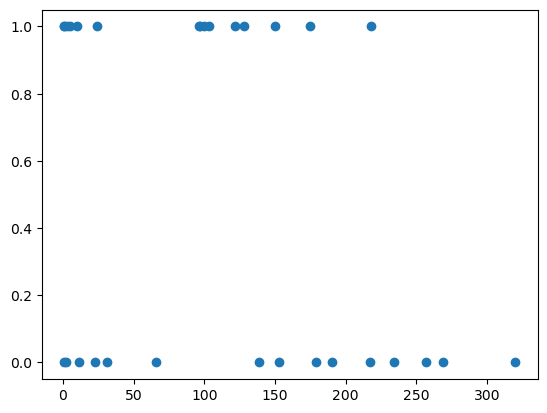

In [636]:
import matplotlib.pyplot as plt

#Initial exploration of Weekend/Weekday Bread sales
#Remeber to swap Weekend and Weeday sales to opposite way round

#This was a 1D array 
#Convert to a np arrays as creates an array of consecutive equally 
#Spaced values
x = np.array(df1['Count']) #features matrix
y = np.array(df1['DayType']) #target model

#Reshape x to be a 2D array with one feature 
x = x.reshape(-1, 1)

plt.scatter(x,y)
plt.show()

#### Spliting Dataset

In [637]:
#Split the data into training and testing sets
from sklearn.model_selection import train_test_split

x_train , x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

#### Standardise Dataa

In [638]:
from sklearn.preprocessing import StandardScaler

#Standardised Dataset = removing the mean and scaling to unit variance
scaler = StandardScaler()

# Fit on training set only
scaler.fit(x_train)

# Apply transform to both the training set and the test set 
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

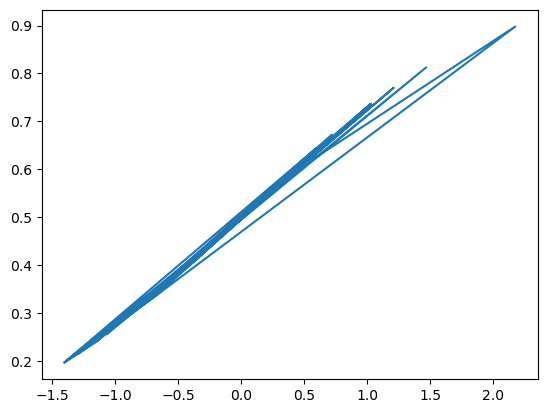

In [639]:
#Established a signmoid function (bounded 1:0)
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+np.exp(-item)))
    return a

sig = sigmoid(x_train)
plt.plot(x_train, sig)

### Fitting Logistic Regression 

In [661]:
logr = LogisticRegression()

#Training the model on the data, learning relationship between x and y
logr.fit(x_train, y_train)

LogisticRegression()

In [662]:
#Set a custom threhold value 
custom_threshold = 0.5

#Calculate the predicted probabilities for the test set
probs = logr.predict_proba(x_test)

#Preditions on the data with the threshold parameter
preds = (probs[:,1] >= custom_threshold).astype(int)

#### Evaluation Metrics
- The model created for predicted if Bread will sell on a weekday or weekend has a good accuracy score of 75%, which is acceptable for bakery industry

In [663]:
#Calculate classification accuracy 
#fraction of correct predictions, total number of data points
score = logr.score(x_test, y_test)
print(score)

0.75


In [664]:
#Creates a confusion matrix
cm = metrics.confusion_matrix(y_test, preds)
cm

array([[2, 1],
       [1, 4]])

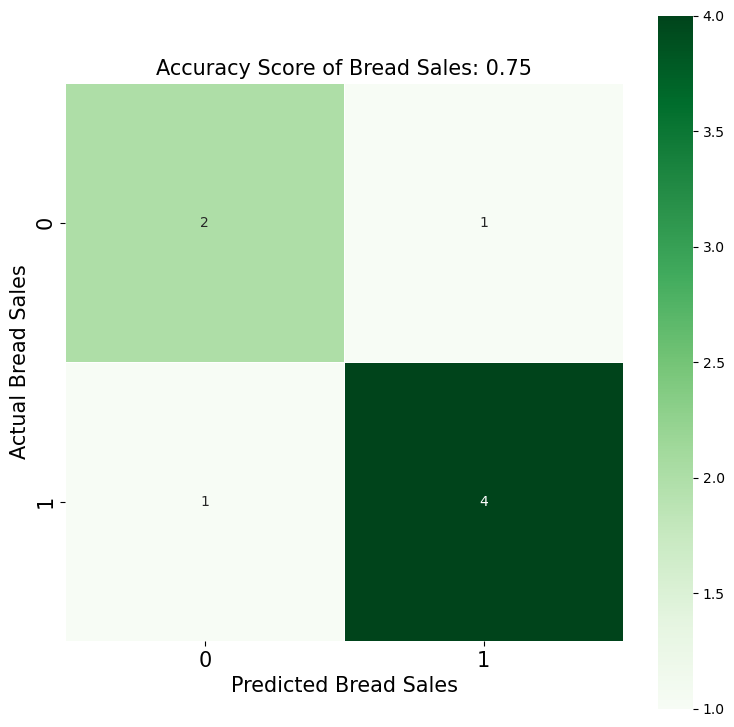

In [665]:
#Visualisation of the confusion matrix 
plt.figure(figsize=(9,9))
sns.heatmap(cm,annot=True,
           fmt=".0f",
           linewidth=.5,
           square=True,
           cmap = "Greens");
    
plt.ylabel('Actual Bread Sales', fontsize = 15);
plt.xlabel('Predicted Bread Sales', fontsize = 15);
plt.title('Accuracy Score of Bread Sales: {}'.format(score), size = 15);
plt.tick_params(labelsize= 15)
    

#### Recall score 
- The recall score for predicting a Weekend Bread sale is excellent at 80%
- The recall score for predicting a Weekday Bread sale is pretty good being between 60% - 70%

In [666]:
# 0 = Weekday, 1 = Weekend
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.80      0.80      0.80         5

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8



#### Sensitivity & Specificity 
- The sensitivity and specificity values are reasonably close together, which is a good sign that both True positives and True negatives are close to equally being predicted

In [667]:
true_pos = cm[1,1]
false_pos = cm[0,1]
true_neg = cm[0,0]
false_neg = cm[1,0]

# Calculate Sensitivity specificity 
sensitivity = true_pos / (true_pos + false_neg)
specificity = true_neg / (true_neg + false_pos)

print('Sensitivity: {:.3f}'.format(sensitivity))
#Our model does extremely  to really pick up on positive cases (True positive rate)
print('Specificity: {:.3f}'.format(specificity))
#However our model does extreme well to predict negative cases (True negative rate)

Sensitivity: 0.800
Specificity: 0.667


### Predicting the quality of bread sold based on the time of the day 

In [694]:
#Nobody is selling bread at 1 am, I am removing it as an outlier
df1 = df1[~(df1['DateTime'] == 1)]

In [693]:
#Removed 8, 9 and 10am as they seemed to beoutliers in the dataset
df1 = df1[~(df1['DateTime'] < 11)]

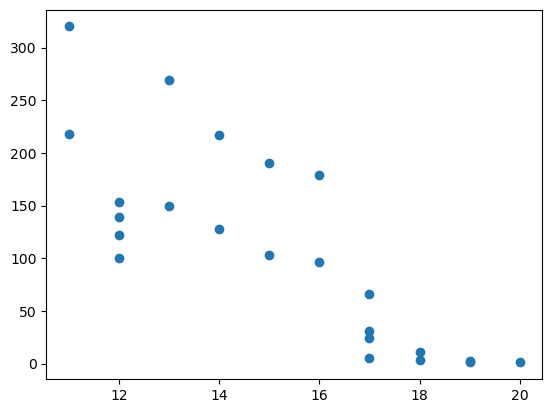

In [695]:
x = np.array(df1['DateTime']) #features matrix
y = np.array(df1['Count']) #target model

x = x.reshape(-1, 1)

plt.scatter(x,y)
plt.show()

In [696]:
x_train , x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

In [697]:
from sklearn.linear_model import LinearRegression

# Make a linear regession instance
lr = LinearRegression()

#Training the model on the data, storing the information learned from the data 
# Model is learning the relationship between x2 and 2y
lr.fit(x_train, y_train)

LinearRegression()

In [698]:
pred = lr.predict(x_train)

<function matplotlib.pyplot.show(close=None, block=None)>

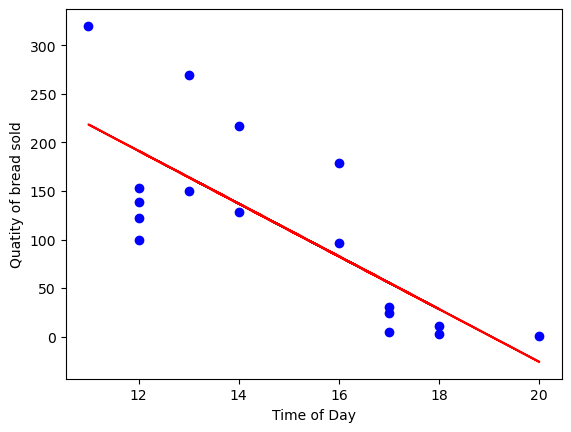

In [699]:
#Plot a regression line / decided to remove all data points before 10
plt.scatter(x_train, y_train, color='blue')
plt.plot(x_train, pred, color = 'red')
plt.xlabel("Time of Day")
plt.ylabel("Quatity of bread sold")
plt.show

In [700]:
# Y = mx + b 
#Finding the intercept (b)
print(f"intercept: {lr.intercept_}")

#Finding the slope (m)
print(f"slope: {lr.coef_}")



intercept: 517.3922542204568
slope: [-27.17328699]


#### Predicting Bread sales based on time of day

In [701]:
print(f" predicted bread based on time of day: \n {pred}")

 predicted bread based on time of day: 
 [ 82.61966236 -26.0734856   55.44637537 136.96623635 164.13952334
  55.44637537 191.31281033 191.31281033 191.31281033  28.27308838
 136.96623635 164.13952334  28.27308838 191.31281033 218.48609732
  55.44637537  82.61966236]


In [702]:
y_pred = lr.intercept_ + np.sum(lr.coef_ * x_train, axis=1)
print(f"predicted response:\n{y_pred}")

predicted response:
[ 82.61966236 -26.0734856   55.44637537 136.96623635 164.13952334
  55.44637537 191.31281033 191.31281033 191.31281033  28.27308838
 136.96623635 164.13952334  28.27308838 191.31281033 218.48609732
  55.44637537  82.61966236]


#### Getting the result properties 
- Making the model predict from 11am onwards dramatically improve the regression models fit to the predicting the bread sales based on time of day (As 0.84 is closer to 1 signifies a better fit to the data) 

In [703]:
score = lr.score(x_test, y_test)
print(f"score: {score}")

coefficient of determination: 0.844999669183315
